# GPyTorch Tutorial

## GPyTorch Regression Tutorial

### Imports

In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data

In [4]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

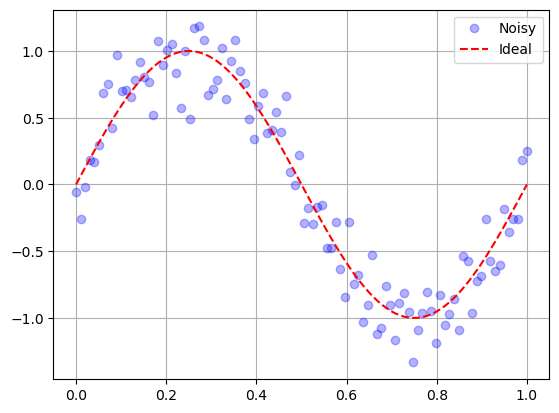

In [17]:
y_ideal = torch.sin(train_x * (2 * math.pi))
plt.plot(train_x,train_y, 'bo', alpha=0.3, label='Noisy')
plt.plot(train_x,y_ideal, 'r--', label='Ideal')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Setting up the model

For most GP regression models, you will need to construct the following GPyTorch objects:

1. A GP Model (`gpytorch.models.ExactGP`) - This handles most of the inference.

1. A Likelihood (`gpytorch.likelihoods.GaussianLikelihood`) - This is the most common likelihood used for GP regression.

1. A Mean - This defines the prior mean of the GP.(If you don’t know which mean to use, a `gpytorch.means.ConstantMean()` is a good place to start.)

1. A Kernel - This defines the prior covariance of the GP.(If you don’t know which kernel to use, a `gpytorch.kernels.ScaleKernel`(`gpytorch.kernels.RBFKernel()`) is a good place to start).

1. A MultivariateNormal Distribution (`gpytorch.distributions.MultivariateNormal`) - This is the object used to represent multivariate normal distributions.

In [18]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [19]:
model

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [23]:
likelihood

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

#### Model modes

Like most PyTorch modules, the ExactGP has a `.train()` and `.eval()` mode. - `.train()` mode is for optimizing model hyperameters. - `.eval()` mode is for computing predictions through the model posterior.

### Training the model

Use Type-II MLE to train the hyperparameters of the Gaussian process.

The most obvious difference here compared to many other GP implementations is that, as in standard PyTorch, the core training loop is written by the user. In GPyTorch, we make use of the standard PyTorch optimizers as from `torch.optim`, and all trainable parameters of the model should be of type `torch.nn.Parameter`. Because GP models directly extend `torch.nn.Module`, calls to methods like `model.parameters()` or `model.named_parameters()` function as you might expect coming from PyTorch.

In most cases, the boilerplate code below will work well. It has the same basic components as the standard PyTorch training loop:

* Zero all parameter gradients
* Call the model and compute the loss
* Call backward on the loss to fill in gradients
* Take a step on the optimizer

However, defining custom training loops allows for greater flexibility. For example, it is easy to save the parameters at each step of training, or use different learning rates for different parameters (which may be useful in deep kernel learning for example).

In [20]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.939   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.908   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.874   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.836   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.793   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.745   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.693   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.641   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.591   lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.546   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.505   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.467   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.431   lengthscale: 0.272   noise: 0.259
Iter 14/50 - Loss: 0.397   lengthscale: 0.256   noise: 0.236
Iter 15/50 - Loss: 0.363   lengthscale: 0.243   noise: 0.216
Iter 16/50 - Loss: 0.329   lengthscale: 0.233   noise: 0.196
Iter 17/50 - Loss: 0.296   length

### Make predictions with the model

In [26]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

In [39]:
observed_pred

MultivariateNormal(loc: torch.Size([51]))

In [28]:
f_preds = model(test_x)
f_preds

MultivariateNormal(loc: torch.Size([51]))

In [29]:
y_preds = likelihood(model(test_x))
y_preds

MultivariateNormal(loc: torch.Size([51]))

In [30]:
f_mean = f_preds.mean
f_mean

tensor([ 0.0102,  0.1419,  0.2685,  0.3881,  0.4993,  0.6007,  0.6912,  0.7697,
         0.8355,  0.8881,  0.9271,  0.9522,  0.9632,  0.9603,  0.9436,  0.9133,
         0.8698,  0.8137,  0.7455,  0.6660,  0.5761,  0.4768,  0.3695,  0.2553,
         0.1359,  0.0130, -0.1116, -0.2361, -0.3583, -0.4763, -0.5879, -0.6912,
        -0.7843, -0.8654, -0.9328, -0.9853, -1.0217, -1.0413, -1.0436, -1.0285,
        -0.9962, -0.9473, -0.8826, -0.8033, -0.7110, -0.6073, -0.4942, -0.3737,
        -0.2480, -0.1192,  0.0103], grad_fn=<ViewBackward0>)

In [31]:
f_var = f_preds.variance
f_var

tensor([0.0071, 0.0044, 0.0030, 0.0022, 0.0019, 0.0019, 0.0019, 0.0019, 0.0018,
        0.0018, 0.0017, 0.0017, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0016, 0.0016, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0015, 0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0016, 0.0016, 0.0017, 0.0017, 0.0018, 0.0018, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0022, 0.0030, 0.0044, 0.0071],
       grad_fn=<ExpandBackward0>)

In [32]:
f_covar = f_preds.covariance_matrix
f_covar

tensor([[ 7.0897e-03,  5.4563e-03,  3.9974e-03,  ..., -4.8994e-05,
         -7.5412e-05, -9.4347e-05],
        [ 5.4555e-03,  4.4277e-03,  3.4757e-03,  ..., -2.0280e-05,
         -4.8054e-05, -7.5410e-05],
        [ 3.9973e-03,  3.4760e-03,  2.9551e-03,  ...,  3.7360e-06,
         -2.0278e-05, -4.8992e-05],
        ...,
        [-4.8994e-05, -2.0278e-05,  3.7369e-06,  ...,  2.9547e-03,
          3.4755e-03,  3.9972e-03],
        [-7.5413e-05, -4.8060e-05, -2.0278e-05,  ...,  3.4758e-03,
          4.4276e-03,  5.4559e-03],
        [-9.4345e-05, -7.5414e-05, -4.8989e-05,  ...,  3.9972e-03,
          5.4557e-03,  7.0904e-03]], grad_fn=<AddmmBackward0>)

In [43]:
f_samples = f_preds.sample(sample_shape=torch.Size([10]))
f_samples

tensor([[-0.1195,  0.0358,  0.2029,  0.3473,  0.4838,  0.6081,  0.7180,  0.7994,
          0.8820,  0.9383,  0.9825,  1.0091,  1.0294,  1.0188,  0.9970,  0.9659,
          0.9159,  0.8586,  0.7845,  0.7033,  0.6094,  0.5006,  0.3940,  0.2738,
          0.1510,  0.0229, -0.1059, -0.2451, -0.3674, -0.4944, -0.6026, -0.7205,
         -0.8146, -0.8988, -0.9721, -1.0326, -1.0709, -1.0877, -1.0988, -1.0787,
         -1.0449, -0.9994, -0.9381, -0.8639, -0.7696, -0.6747, -0.5762, -0.4563,
         -0.3507, -0.2331, -0.1248],
        [-0.1093,  0.0409,  0.1820,  0.3136,  0.4329,  0.5359,  0.6353,  0.7174,
          0.7802,  0.8408,  0.8795,  0.9032,  0.9203,  0.9179,  0.9152,  0.8936,
          0.8642,  0.8228,  0.7714,  0.7036,  0.6335,  0.5450,  0.4528,  0.3534,
          0.2416,  0.1176, -0.0039, -0.1270, -0.2602, -0.3901, -0.5135, -0.6300,
         -0.7331, -0.8327, -0.9112, -0.9775, -1.0285, -1.0508, -1.0615, -1.0473,
         -1.0269, -0.9796, -0.9196, -0.8359, -0.7424, -0.6457, -0.5375, 

### Plot the model fit

The `confidence_region` method is a helper method that returns 2 standard deviations above and below the mean.

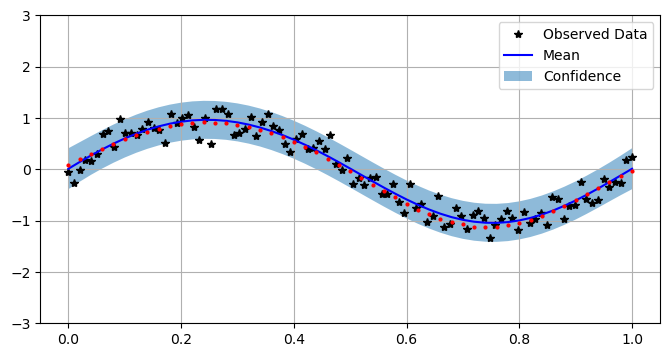

In [47]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 4))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # Random sample of possible solution
    ax.plot(test_x,f_samples[5], 'ro', markersize=2)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.grid(True)